# Mini-Challenge 1: Hyperparameter und Model Tuning 

In [60]:
import pandas as pd
import numpy as np
import random
import os
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split


from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score
from matplotlib.pyplot import figure

## Ausgangslage:

Das Ziel diese Mini-Challenge ist es ein neuronales Netzwerk zu Implementieren, trainiern und zu validieren. Das Model sollte ein Klassifikationstask sein mit selbst vorgeschlagenem Datenset. Mit einem Srcaper habe ich von der Website https://unsplash.com/ Bilder von 5 verschiedenen Tieren entnommen. 

## 1. Explore the Data

### 1.1 Volume

In [65]:
animals = ["bird","cat","dog","fish","horse"]
volume = []
print("Klassen:")
for animal in animals:
    folder_train="Data/train/"+animal
    folder_test="Data/test/"+animal
    list1 = os.listdir(folder_train)
    list2 = os.listdir(folder_test)
    number_files = len(list1) + len(list2)
    print(animal, number_files)
    volume.append(number_files)
    
print("\nAlle Klassen Zusammen: {}".format(sum(volume)))

Klassen:
bird 9785
cat 9961
dog 8123
fish 9403
horse 8940

Alle Klassen Zusammen: 46212


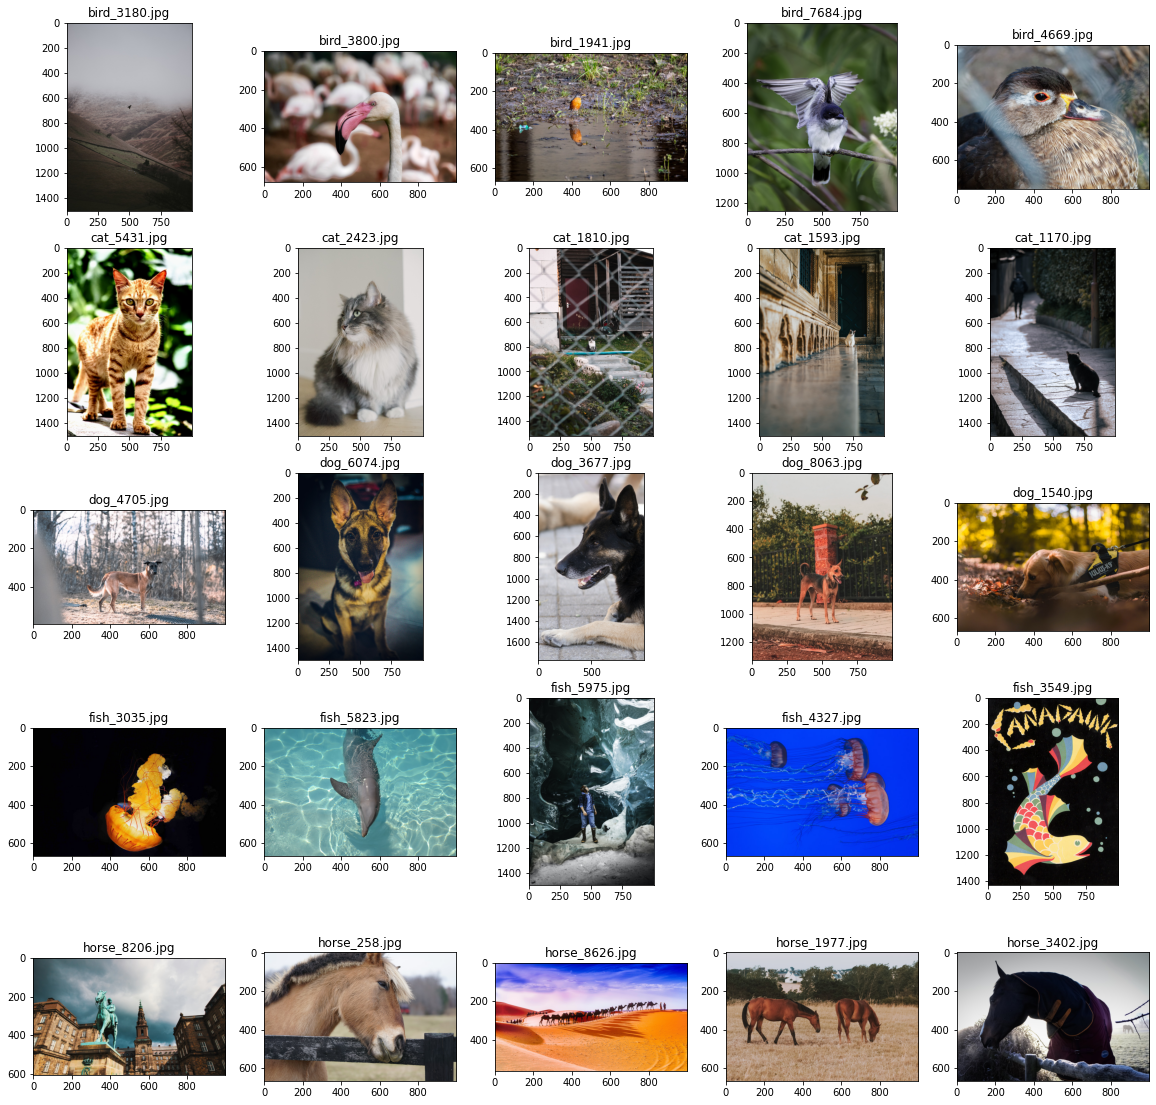

In [66]:
plt.figure(figsize=(20,20))
animals = ["bird","cat","dog","fish","horse"]
k = 0
random.seed(4)

for animal in animals:
    test_folder="Data/train/"+animal
    
    for i in range(5):
        file = random.choice(os.listdir(test_folder))
        image_path= os.path.join(test_folder, file)
        img=mpimg.imread(image_path)
        ax=plt.subplot(5,5,k+1)
        ax.title.set_text(file)
        plt.imshow(img)
        k = k+1    

### 1.3 Preprocess and load Data

In [4]:
def image_loader(image_size=32, batch_size=4, root="Images/",num_workers=2,shuffle=False):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    data_set = torchvision.datasets.ImageFolder(root=root, transform=transform)
    data_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

    return data_loader

classes = ("bird","cat","dog","fish","horse")

In [47]:
train_path='Data/train/'
test_path='Data/test/'
batch_size = 32

trainloader = image_loader(batch_size = batch_size,root=train_path,shuffle=True)
testloader = image_loader(batch_size = batch_size,root=test_path,shuffle=False)

## 2. Define the Modell

### 2.1 Metrics

At the beginning we will visualize a confusion matrix and can see how the model behaves and which values result. Then we derive the following metrics from this and can compare the different models.
$$Precision = \frac{TP} {TP+FP}$$

$$Recall = \frac{TP} {TP+FN}$$

$$F_1 =\big{(}\frac{1/Precision+1/Recall} {2}\big{)}^{-1}$$

The Precision is calculated as in the equation below and indicates the proportion of correctly predicted positive results (TP) in relation to the total of all results predicted as positive (P).
The recall indicates the proportion of results correctly classified as positive (TP) in relation to the totality of actually positive results (P). The F1 score is the harmonic mean of Precision and Recall and is often used as a summary metric. Therefore we will mainly use F1-Score as our metric


### 2.2 Basic functionality

## 3. Training with SGD (without REG, without BN)

In [52]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [54]:
model = net.to(device)

In [55]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [57]:
train_losses = []
valid_losses = []

for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training-the-model
    model.train()
    for data, target in trainloader:
        # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        
    # validate-the-model
    model.eval()
    for data, target in valid_loader:
        
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        
        loss = criterion(output, target)
        
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

NameError: name 'valid_loader' is not defined

In [36]:
# defining the model
model = net.to(device)
# defining the optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# defining the loss function
criterion = nn.CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [27]:
for i in range(10):
    running_loss = 0
    for images, labels in trainloader:
        images, labels = images.cuda().to(device), labels.cuda().to(device)

        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(i+1, running_loss/len(trainloader)))

Epoch 1 - Training loss: 1.4154843798351948
Epoch 2 - Training loss: 1.3933017837547514
Epoch 3 - Training loss: 1.3834336057150654
Epoch 4 - Training loss: 1.3707541706343422
Epoch 5 - Training loss: 1.3600074801993618
Epoch 6 - Training loss: 1.3529550461517486
Epoch 7 - Training loss: 1.344732675946295
Epoch 8 - Training loss: 1.3388009687505378
Epoch 9 - Training loss: 1.3274020919750307
Epoch 10 - Training loss: 1.3205012143380088


In [45]:
import time
import copy

In [50]:
def train_model(model, num_epochs=10):
    since = time.time()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')

            for inputs, labels in trainloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [51]:
base_model = train_model(model, num_epochs=3)

Epoch 0/2
----------
Iterating through data...


NameError: name 'dataset_sizes' is not defined

In [30]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [31]:
num_epochs = 30
opt_func = torch.optim.SGD
lr = 0.001

#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, trainloader, testloader)

AttributeError: 'Net' object has no attribute 'training_step'

NameError: name 'history' is not defined

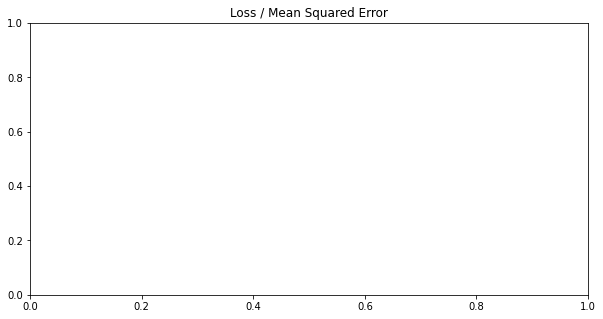

In [14]:
figure(figsize=(10, 5))
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [20]:
train_losses, test_losses = [], []

for epoch in range(2):  # loop over the dataset multiple times
    test_loss = 0
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))  



print('Finished Training')

KeyboardInterrupt: 

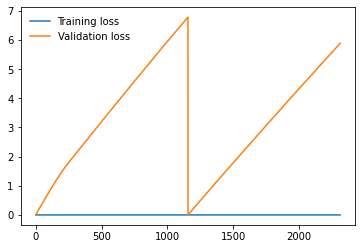

In [18]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [68]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 44 %


In [83]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (fc): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=10, bias=True)
    (4): LogSoftmax(dim=1)
  )
)

In [5]:
epochs = 1
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = data[0].to(device), data[1].to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

NameError: name 'trainloader' is not defined

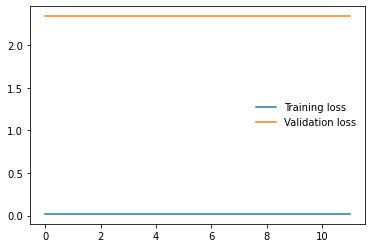

In [82]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

AttributeError: 'Net' object has no attribute 'history'

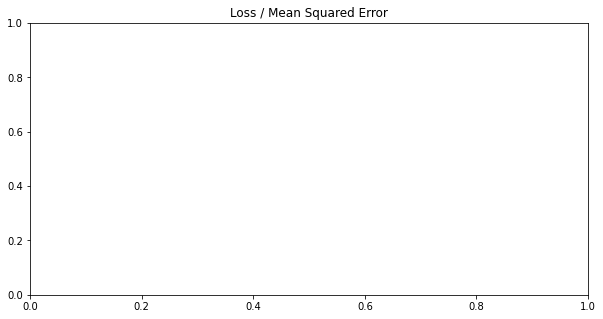

In [57]:
# plot loss during training
figure(figsize=(10, 5))
plt.title('Loss / Mean Squared Error')
plt.plot(model.history['loss'], label='train')
plt.plot(model.history['val_loss'], label='test')
plt.legend()
plt.show()

In [30]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchviz import make_dot

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Our data was in Numpy arrays, but we need to transform them into PyTorch's Tensors
# and then we send them to the chosen device
X_train_tensor = torch.from_numpy(X_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

# Here we can see the difference - notice that .type() is more useful
# since it also tells us WHERE the tensor is (device)
print(type(X_train), type(X_train_tensor), X_train_tensor.type())

<class 'numpy.ndarray'> <class 'torch.Tensor'> torch.cuda.FloatTensor


In [39]:
X_train_tensor.shape

torch.Size([28, 3, 50, 50])

In [42]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

tensor([0.1940], device='cuda:0', requires_grad=True) tensor([0.1391], device='cuda:0', requires_grad=True)


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [19]:
batch_size = 32
trainloader = image_loader(batch_size = batch_size,root=train_path,shuffle=True)

In [20]:
sample_data = iter(trainloader)
images, labels = sample_data.next()

In [33]:
images.shape

(32, 3, 50, 50)

In [22]:
images = (images.numpy())
labels = (labels.numpy())
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=42)

In [23]:
X_train.shape

(28, 3, 50, 50)

In [24]:
X_test.shape

(4, 3, 50, 50)

In [36]:
X_train = X_train.reshape(X_train.shape[0],3*50*50)
X_test = X_test.reshape(X_test.shape[0],3*50*50)

In [14]:
sgd_clf = SGDClassifier(random_state=42) # instantiate
sgd_clf.fit(X_train, y_train) # train the classifier

SGDClassifier(random_state=42)

In [15]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")
# array([0.96485, 0.95 , 0.9494 ])
# We get accuracy for each fold = 96.45%, 95%, 94.94%

array([0.3       , 0.22222222, 0.33333333])

In [16]:
classes = ["bird","cat","dog","fish","horse"]

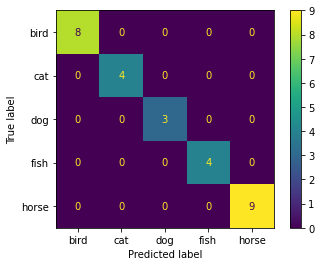

In [17]:
plot_confusion_matrix(sgd_clf, X_train, y_train,display_labels=classes)
plt.show()

ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of ticklabels (5).

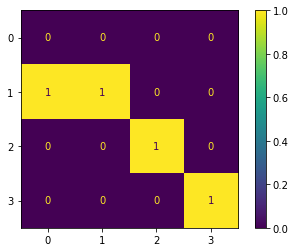

In [18]:
plot_confusion_matrix(sgd_clf, X_test, y_test,display_labels=classes)
plt.show()

In [22]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

In [23]:
precision_score(y_train, y_train_pred,average="macro")

0.30046633014948565

In [24]:
recall_score(y_train, y_train_pred,average="macro")

0.2941145348875628

In [ ]:
import torch

# andere test:

In [19]:
from sklearn.datasets import make_circles
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from matplotlib import pyplot

In [2]:
import torch

In [29]:
X_train = torch.FloatTensor([0., 1., 2.])
X_train.is_cuda

False

In [27]:
torch.cuda.is_available()

False

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [190]:
# define model
model = Sequential()
model.add(Dense(250, input_dim=7500, activation='relu', kernel_initializer='he_uniform'))
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='mean_squared_error', optimizer=opt)

In [191]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, verbose=0)

In [192]:
# evaluate the model
train_mse = model.evaluate(X_train, y_train, verbose=0)
test_mse = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

Train: 1.416, Test: 2.096


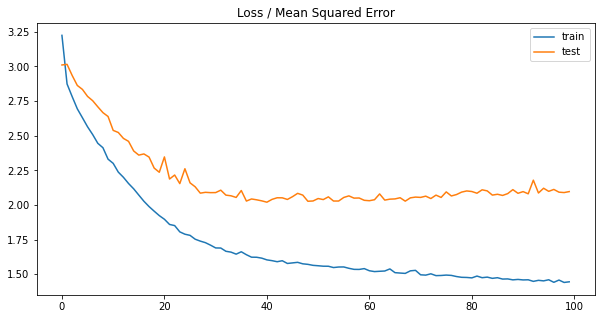

In [193]:
# plot loss during training
figure(figsize=(10, 5))
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 4. Benefits of Regularization

### 4.1 Different regularization methods

### 4.2 Evaluation

## 5  Benefits of Batchnorm BN (without REG, with SGD)

## 6.  Benefits of Adam (without BN, without/with REG)

### 5.1 Evaluation

### 5.2 Interpretieren